In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Paths to the datasets
base_path = "D:\\brain tumor\\Training"

In [3]:
# Parameters
img_size = (224, 224)  # Standard input size for MobileNetV2
batch_size = 32

In [4]:
# Load and split the data into training, validation, and testing sets
files = []
labels = []
for label in os.listdir(base_path):
    class_dir = os.path.join(base_path, label)
    if os.path.isdir(class_dir):
        files.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir)])
        labels.extend([label] * len(os.listdir(class_dir)))


In [5]:
# Split data into training+validation and testing sets first
train_valid_files, test_files, train_valid_labels, test_labels = train_test_split(
    files, labels, test_size=0.15, random_state=42
)

# Split training+validation into training and validation sets
train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_valid_files, train_valid_labels, test_size=0.1765, random_state=42  # 0.1765 is approximately 15% of 85%
)

In [6]:
 #ImageDataGenerators for training, validation, and testing
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,             # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,         # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,        # randomly shift images vertically (fraction of total height)
    shear_range=0.2,               # apply shearing transformation
    zoom_range=0.2,                # randomly zoom into images
    horizontal_flip=True,          # randomly flip images horizontally
    fill_mode='nearest'            # strategy for filling in newly created pixels, which can appear after a rotation or a width/height shift
).flow_from_dataframe(
    pd.DataFrame({'filepaths': train_files, 'labels': train_labels}),
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    pd.DataFrame({'filepaths': valid_files, 'labels': valid_labels}),
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    pd.DataFrame({'filepaths': test_files, 'labels': test_labels}),
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 4915 validated image filenames belonging to 4 classes.
Found 1054 validated image filenames belonging to 4 classes.
Found 1054 validated image filenames belonging to 4 classes.


In [10]:
# Initialize the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size + (3,))  

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Create the model's head (top layers)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(set(train_labels)), activation='softmax')(x)

In [12]:
# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('MobileNetV2_Brain.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)


In [17]:
# Train the model
history=model.fit(train_gen, 
          validation_data=valid_gen, 
          epochs=100,
          steps_per_epoch=len(train_gen), 
          validation_steps=len(valid_gen),
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8183
Epoch 1: val_loss improved from inf to 0.33283, saving model to MobileNetV2_Brain.keras
154/154 [==============================] - 53s 344ms/step - loss: 0.4773 - accuracy: 0.8183 - val_loss: 0.3328 - val_accuracy: 0.8748
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8832
Epoch 2: val_loss improved from 0.33283 to 0.25703, saving model to MobileNetV2_Brain.keras
154/154 [==============================] - 55s 355ms/step - loss: 0.3081 - accuracy: 0.8832 - val_loss: 0.2570 - val_accuracy: 0.9080
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9093
Epoch 3: val_loss improved from 0.25703 to 0.24273, saving model to MobileNetV2_Brain.keras
154/154 [==============================] - 56s 364ms/step - loss: 0.2428 - accuracy: 0.9093 - val_loss: 0.2427 - val_accuracy: 0.9013
Epoch 4/100
154/154 [==============

In [ ]:
#Training and validation Accuracy and loss graph

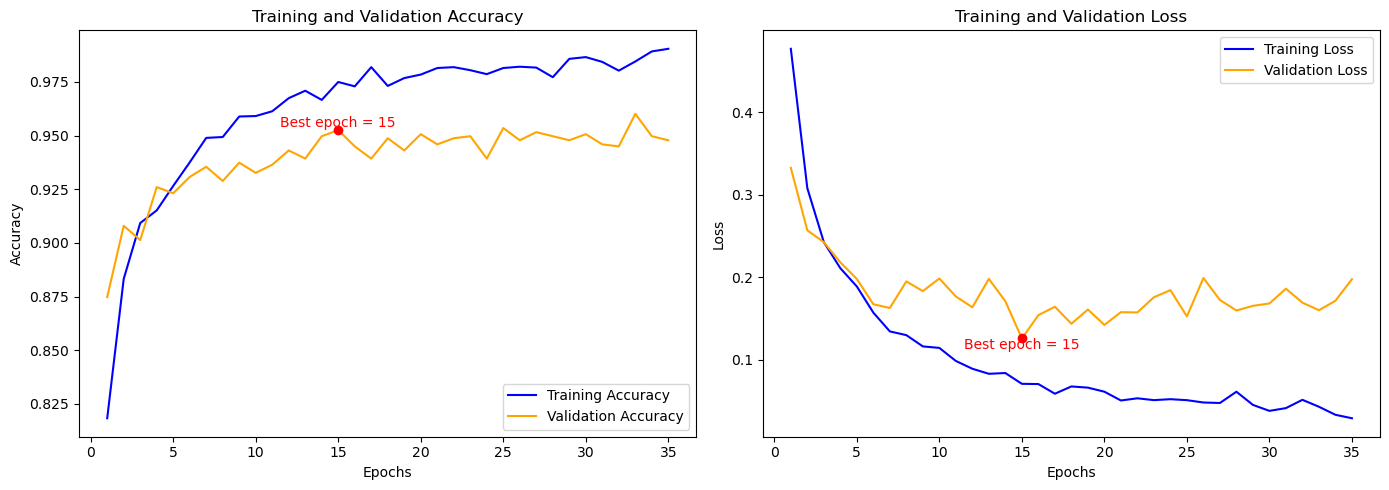

In [20]:
import matplotlib.pyplot as plt

# Extracting data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Finding the best epoch (the one with the lowest validation loss)
best_epoch = val_loss.index(min(val_loss)) + 1

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
plt.scatter(best_epoch, val_acc[best_epoch - 1], color='red', zorder=5)  # Mark the best epoch
plt.text(best_epoch, val_acc[best_epoch - 1], f'Best epoch = {best_epoch}', color='red', ha='center', va='bottom')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.scatter(best_epoch, val_loss[best_epoch - 1], color='red', zorder=5)  # Mark the best epoch
plt.text(best_epoch, val_loss[best_epoch - 1], f'Best epoch = {best_epoch}', color='red', ha='center', va='top')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
#Evaluation on test data

In [7]:
from tensorflow.keras.models import load_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img




33/33 [==============================] - 11s 285ms/step - loss: 0.1966 - accuracy: 0.9355
Test Loss: 0.19660288095474243
Test Accuracy: 0.9354838728904724
33/33 [==============================] - 10s 290ms/step


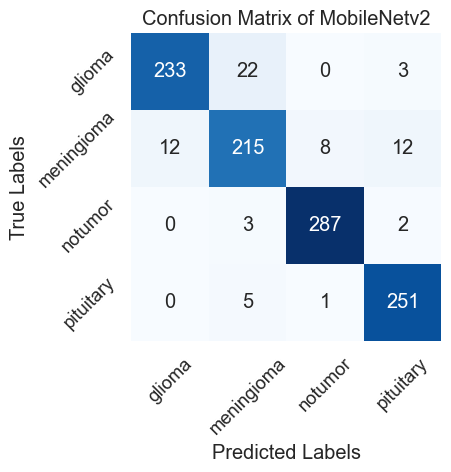


Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.90      0.93       258
  meningioma       0.88      0.87      0.87       247
     notumor       0.97      0.98      0.98       292
   pituitary       0.94      0.98      0.96       257

    accuracy                           0.94      1054
   macro avg       0.93      0.93      0.93      1054
weighted avg       0.94      0.94      0.94      1054



In [10]:
model = load_model('MobileNetV2_Brain.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Predict the test set
test_preds = model.predict(test_gen, steps=len(test_gen))

# Convert predictions from one-hot encoded vectors to class indices
predicted_classes = np.argmax(test_preds, axis=1)

# Retrieve true class labels from the test generator
true_classes = test_gen.classes

# Class labels (ensure these are in the same order as the generator's classes)
class_labels = list(test_gen.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of MobileNetv2')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print("\nClassification Report:")
print(class_report)
